In [1]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# do all of the imports
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import arange

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# from sklearn.metrics import confusion_matrix
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras import layers

import joblib
import re
import seaborn as sns
import pydot


import matplotlib.pyplot as plt
import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_eliot3.csv")
# df = pd.read_csv("Resource/IMDB_eliot2.csv")
df.head()

,Unnamed: 0,index,movie_id,movie_name,genre,plot
0,0,76,tt0006864,Intolerance,"drama, history",intolerance story poor young woman separated p...
1,1,506,tt0017136,Metropolis,"drama, sci-fi",metropolis futuristic city sharply divided wor...
2,2,566,tt0018037,Il cantante di jazz,"drama, music, musical",il cantante di jazz son jewish cantor must def...
3,3,628,tt0018773,Il circo,"comedy, romance",il circo tramp finds work girl dreams circus
4,4,714,tt0019777,The Cocoanuts,"comedy, musical",cocoanuts florida land boom


In [4]:
df = df.drop(["Unnamed: 0", "index"], axis=1)
df["genre"] = df["genre"].str.replace(' ', '')
df["genre"] = df["genre"].str.split(",")
df.head()

,movie_id,movie_name,genre,plot
0,tt0006864,Intolerance,"[drama, history]",intolerance story poor young woman separated p...
1,tt0017136,Metropolis,"[drama, sci-fi]",metropolis futuristic city sharply divided wor...
2,tt0018037,Il cantante di jazz,"[drama, music, musical]",il cantante di jazz son jewish cantor must def...
3,tt0018773,Il circo,"[comedy, romance]",il circo tramp finds work girl dreams circus
4,tt0019777,The Cocoanuts,"[comedy, musical]",cocoanuts florida land boom


In [5]:
# get all genre tags in a list
all_genres = sum(df["genre"],[])
len(set(all_genres))

21

In [6]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

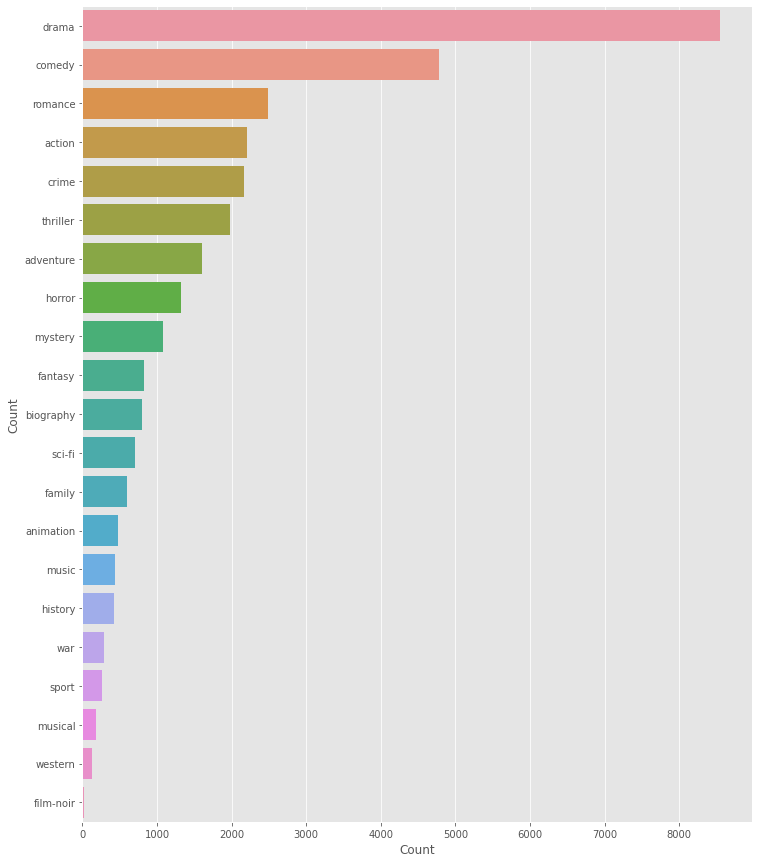

In [7]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

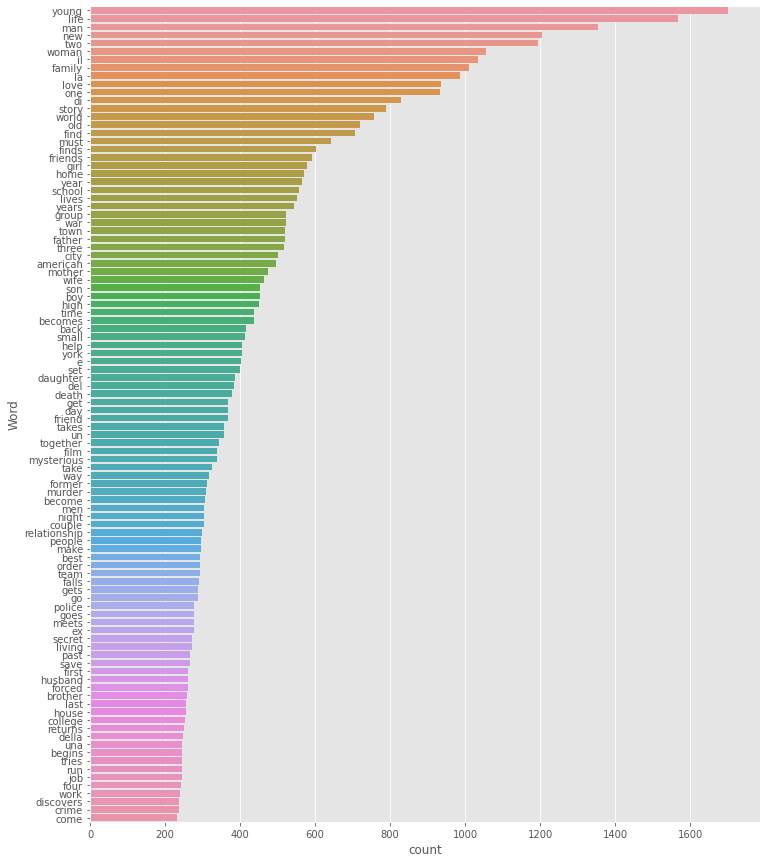

In [8]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['plot'], 100)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(df['genre'])

y = multilabel_binarizer.fit_transform(df['genre'])

# transform target variable
list(multilabel_binarizer.classes_)

['action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'sport',
 'thriller',
 'war',
 'western']

In [10]:
# Define the X and y parameters
sentences = df["plot"]

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# scale the data with StandardScaler
X_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# # Label Encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# # joblib.dump(label_encoder, "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_logistic_regression_le.sav")
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

In [11]:
# Run Random Forest
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train_scaled, y_train)
score = classifier.score(X_test_scaled, y_test)

print("Accuracy:", score)
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Accuracy: 0.12319277108433735
Training Data Score: 1.0
Testing Data Score: 0.12319277108433735


In [16]:
# Hyperparameter Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model_random = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=10, verbose=3, random_state=42)
model_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=0.128, total=  11.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=0.111, total=  11.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=0.104, total=  11.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=0.117, total=  11.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, score=0.127, total=  11.2s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, score=0.129, total= 1.1min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 64.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [17]:
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/Eliot_Random_Forest.sav"
joblib.dump(model_random.best_estimator_, file_name, compress = 1)

['gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/Eliot_Random_Forest.sav']

In [18]:
export_graphviz(model_random.best_estimator_[0], out_file="gdrive/MyDrive/Colab Notebooks/Final-Project/rf_tree.dot")

In [19]:
(graph,) = pydot.graph_from_dot_file("gdrive/MyDrive/Colab Notebooks/Final-Project/rf_tree.dot")

In [28]:
graph.write_png("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/RF_Tree_Eliot.png")

In [22]:
y_pred = classifier.predict(X_test_scaled)

multilabel_binarizer.inverse_transform(y_pred)[:10]

[(),
 ('drama',),
 ('drama',),
 ('drama',),
 ('drama',),
 ('comedy', 'drama'),
 ('drama',),
 ('drama',),
 ('drama',),
 ('drama',)]

In [23]:
# evaluate performance
f1_score(y_test, y_pred, average="micro")

0.4514861633071405

In [26]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower()
    
    return text

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = vectorizer.transform([q])
    q_pred = classifier.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [27]:
for i in range(5): 
  k = sentences_test.sample(1).index[0] 
  print("Movie: ", df['movie_name'][k], "\nPredicted genre: ", infer_tags(sentences_test[k])), print("Actual genre: ",df['genre'][k], "\n")

Movie:  Innamorarsi a Manhattan 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'family', 'romance'] 

Movie:  Tales of Halloween 
Predicted genre:  [()]
Actual genre:  ['comedy', 'horror'] 

Movie:  And Now a Word from Our Sponsor 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'drama'] 

Movie:  Dollars to Freedom 
Predicted genre:  [('drama',)]
Actual genre:  ['action', 'drama'] 

Movie:  Eating Out 
Predicted genre:  [('comedy', 'drama', 'romance')]
Actual genre:  ['comedy', 'drama', 'romance'] 

